In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
! ls /data/sg/ashutiwa/final_crosswalk_temp/airport/airport_one/

airport_adj_crosswalk.npz
airport_adj_fairwalk.npz
airport_adj.npz
airport_crosswalk_deepwalk.npy
airport_crosswalk_node2vec.npy
airport_deepwalk_128_embs.npy
airport_deepwalk.npy
airport_fairwalk_deepwalk.npy
airport_fairwalk_node2vec.npy
airport_gat_None_deepwalk_deepwalk_embs.npy
airport_gat_None_deepwalk_deepwalk.h5
airport_gat_None_deepwalk_r2v_embs.npy
airport_gat_None_deepwalk_r2v.h5
airport_gat_None_node2vec_deepwalk_embs.npy
airport_gat_None_node2vec_deepwalk.h5
airport_gat_None_node2vec_r2v_embs.npy
airport_gat_None_node2vec_r2v.h5
airport_gcn_None_deepwalk_deepwalk_embs.npy
airport_gcn_None_deepwalk_deepwalk.h5
airport_gcn_None_deepwalk_r2v_embs.npy
airport_gcn_None_deepwalk_r2v.h5
airport_gcn_None_node2vec_deepwalk_embs.npy
airport_gcn_None_node2vec_deepwalk.h5
airport_gcn_None_node2vec_r2v_embs.npy
airport_gcn_None_node2vec_r2v.h5
airport_node2vec_128_embs.npy
airport_node2vec.npy
airport_residual2vec_128_embs.npy
airport_test_adj.npz


In [4]:
y = snakemake_utils.get_dataset("airport").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk_temp/airport/'

DIRS = ['airport_one/', 'airport_two/', 'airport_three/', 'airport_four/', 'airport_five/']
DATASET = 'airport'

model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    "deepwalk": "_deepwalk_128_embs.npy",
    "node2vec": "_node2vec_128_embs.npy",
    "residual2vec": "_residual2vec_128_embs.npy"
    
    
}

M = list(model_to_embs.keys())
TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk_temp/airport/airport_one/airport_test_adj.npz'
NUM_NODES=2898
k=5

# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# residual2vec

In [8]:
model = "residual2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


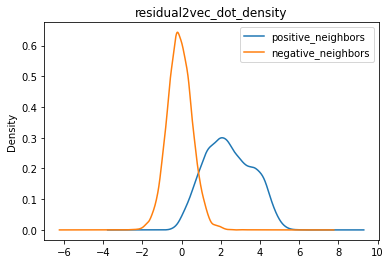

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 117.97it/s]


((14490, 2), 0.006704237302596977, 0.9735065397602162, 0.6871741535378327)

# deepwalk

In [11]:
model = "deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


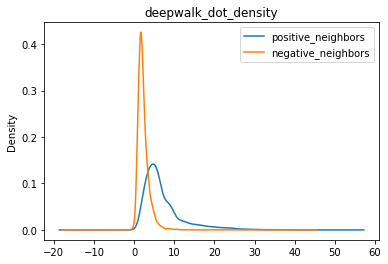

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 203.13it/s]


((14490, 2), 0.008139183463050237, 0.907353393386056, 0.7498710819931774)

# node2vec

In [14]:
model = "node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


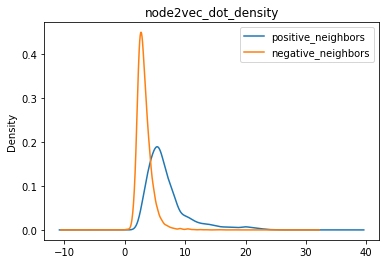

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 193.70it/s]


((14484, 2), 0.008235636034446365, 0.9076886996031059, 0.7479160628088555)

# fairwalk+deepwalk

In [17]:
model = "fairwalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


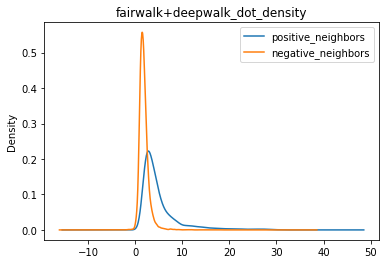

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 186.61it/s]


((14490, 2), 0.007748856240929637, 0.8872473615834396, 0.7292484211217444)

# fairwalk+node2vec

In [20]:
model = "fairwalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(2898, 128)

selected edge_idx size: 13702


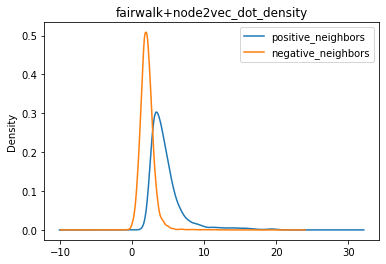

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 202.56it/s]


((14482, 2), 0.007909863809505247, 0.9340111377995846, 0.7315923033805074)

# crosswalk+deepwalk

In [23]:
model = "crosswalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


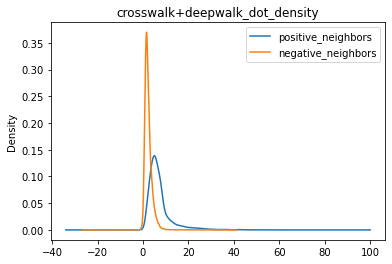

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 196.77it/s]


((14490, 2), 0.00790208359294123, 0.9047220289515976, 0.7368884185954058)

# crosswalk+node2vec

In [26]:
model = "crosswalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


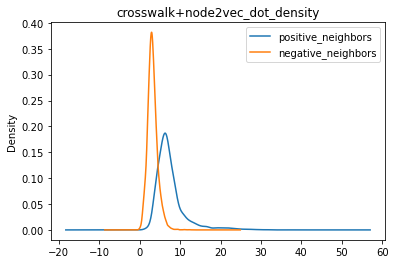

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 206.69it/s]


((14490, 2), 0.0082649814892872, 0.9420269708236507, 0.7472966096718706)

# GCN+deepwalk+random

In [29]:
model = "GCN+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


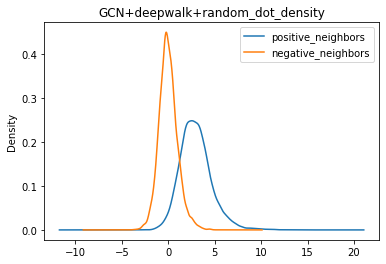

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 286.09it/s]


((14490, 2), 0.008110709527186276, 0.9446221771335946, 0.7489396812432589)

# GCN+deepwalk+r2v

In [32]:
model = "GCN+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(2898, 128)

selected edge_idx size: 13702


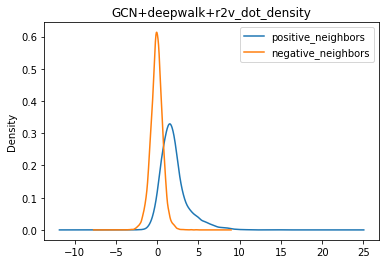

In [33]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [34]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 260.94it/s]


((14490, 2), 0.007390973689497253, 0.9144689538252149, 0.7210070055420755)

# GCN+node2vec+random

In [35]:
model = "GCN+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


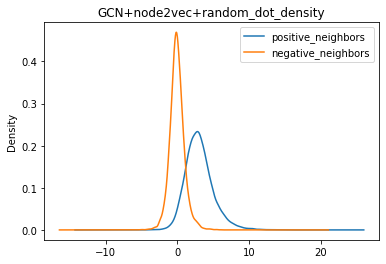

In [36]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [37]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 240.38it/s]


((14490, 2), 0.008129451593068639, 0.9396607535407477, 0.7462631920134601)

# GCN+node2vec+r2v

In [38]:
model = "GCN+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


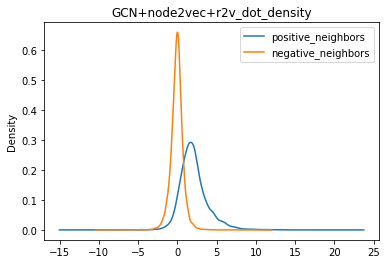

In [39]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [40]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 287.52it/s]


((14490, 2), 0.007802888725108732, 0.9026482831450292, 0.7306571333220404)

# GAT+deepwalk+random

In [41]:
model = "GAT+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


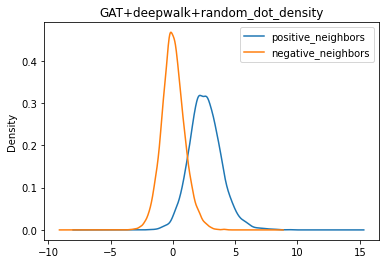

In [42]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [43]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 262.24it/s]


((14484, 2), 0.00782537495215727, 0.9529997591837482, 0.7430412017090464)

# GAT+deepwalk+r2v

In [44]:
model = "GAT+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


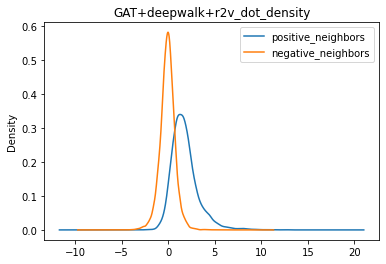

In [45]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [46]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 276.40it/s]


((14490, 2), 0.006711954303473904, 0.9002245649365614, 0.6908797197495496)

# GAT+node2vec+random

In [47]:
model = "GAT+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


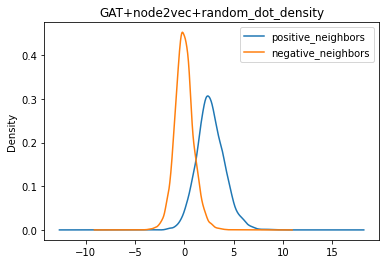

In [48]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [49]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 249.75it/s]


((14486, 2), 0.008122379138151057, 0.9453645598628658, 0.7448238002935876)

# GAT+node2vec+r2v

In [50]:
model = "GAT+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(2898, 128)

selected edge_idx size: 13702


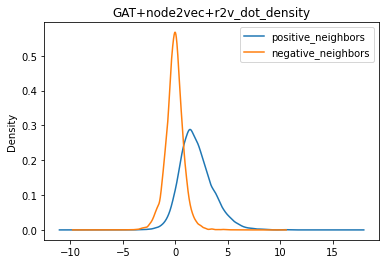

In [51]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [52]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 277.73it/s]


((14490, 2), 0.007941590069280208, 0.8957950069286605, 0.7318487185660338)

# plot statistical parity scores

# gini sp scores

residual2vec 0.6871741535378327
deepwalk 0.7498710819931774
node2vec 0.7479160628088555
fairwalk+deepwalk 0.7292484211217444
fairwalk+node2vec 0.7315923033805074
crosswalk+deepwalk 0.7368884185954058
crosswalk+node2vec 0.7472966096718706
GCN+deepwalk+random 0.7489396812432589
GCN+deepwalk+r2v 0.7210070055420755
GCN+node2vec+random 0.7462631920134601
GCN+node2vec+r2v 0.7306571333220404
GAT+deepwalk+random 0.7430412017090464
GAT+deepwalk+r2v 0.6908797197495496
GAT+node2vec+random 0.7448238002935876
GAT+node2vec+r2v 0.7318487185660338


Text(0.5, 1.0, 'gini statistical parity scores')

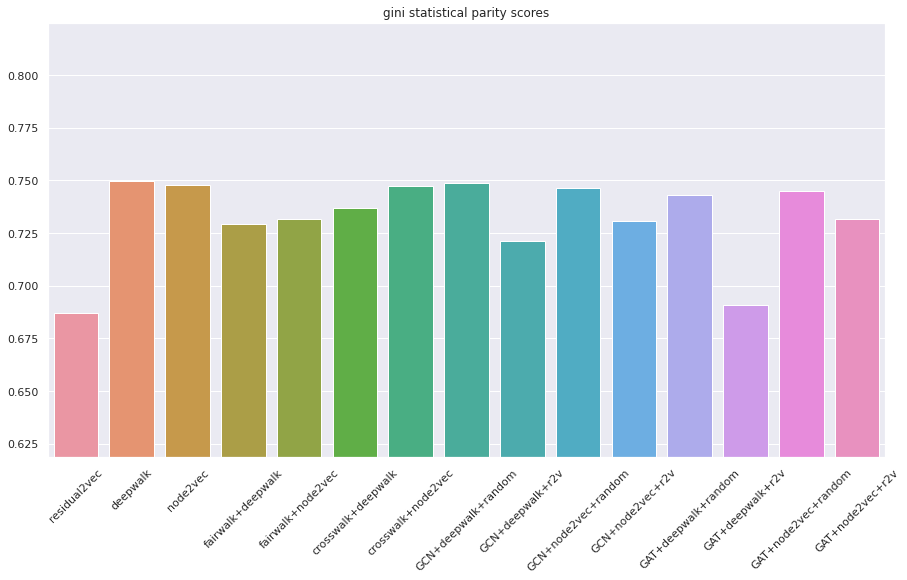

In [53]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

residual2vec 0.006704237302596977
deepwalk 0.008139183463050237
node2vec 0.008235636034446365
fairwalk+deepwalk 0.007748856240929637
fairwalk+node2vec 0.007909863809505247
crosswalk+deepwalk 0.00790208359294123
crosswalk+node2vec 0.0082649814892872
GCN+deepwalk+random 0.008110709527186276
GCN+deepwalk+r2v 0.007390973689497253
GCN+node2vec+random 0.008129451593068639
GCN+node2vec+r2v 0.007802888725108732
GAT+deepwalk+random 0.00782537495215727
GAT+deepwalk+r2v 0.006711954303473904
GAT+node2vec+random 0.008122379138151057
GAT+node2vec+r2v 0.007941590069280208


Text(0.5, 1.0, 'statistical parity scores')

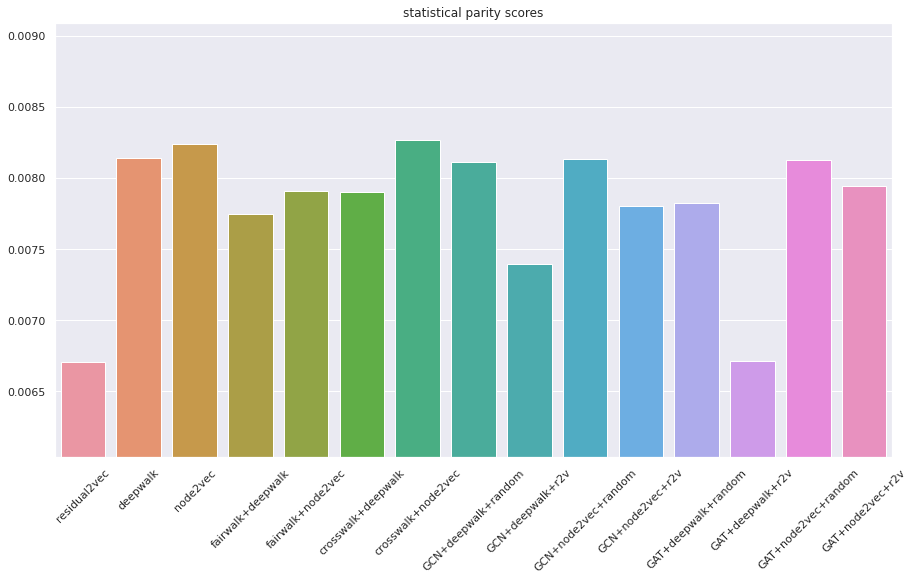

In [54]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

residual2vec 0.9735065397602162
deepwalk 0.907353393386056
node2vec 0.9076886996031059
fairwalk+deepwalk 0.8872473615834396
fairwalk+node2vec 0.9340111377995846
crosswalk+deepwalk 0.9047220289515976
crosswalk+node2vec 0.9420269708236507
GCN+deepwalk+random 0.9446221771335946
GCN+deepwalk+r2v 0.9144689538252149
GCN+node2vec+random 0.9396607535407477
GCN+node2vec+r2v 0.9026482831450292
GAT+deepwalk+random 0.9529997591837482
GAT+deepwalk+r2v 0.9002245649365614
GAT+node2vec+random 0.9453645598628658
GAT+node2vec+r2v 0.8957950069286605


Text(0.5, 1.0, 'roc scores')

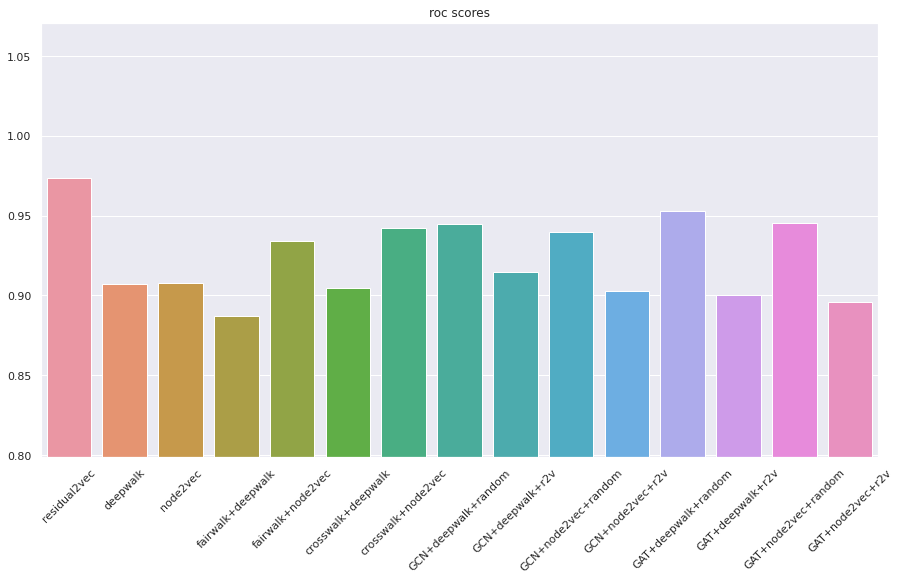

In [55]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [56]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        edges = snakemake_utils.return_new_graph(A, k, )
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 273.99it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 181.49it/s]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 257.87it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

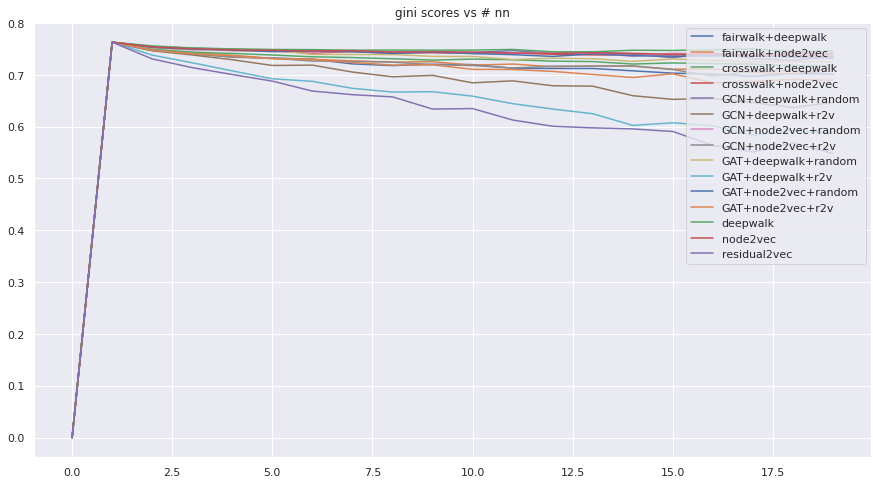

In [57]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

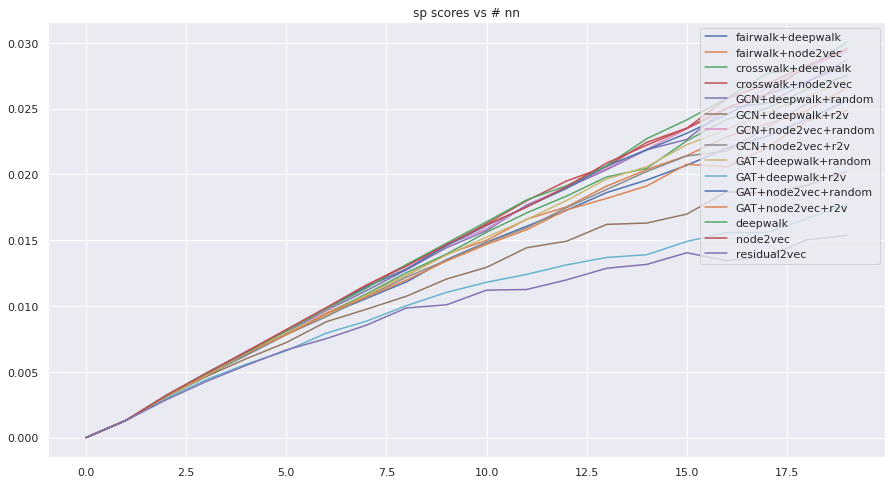

In [58]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [59]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        edges = snakemake_utils.return_new_graph(A, K)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected e

Text(0.5, 1.0, 'roc scores')

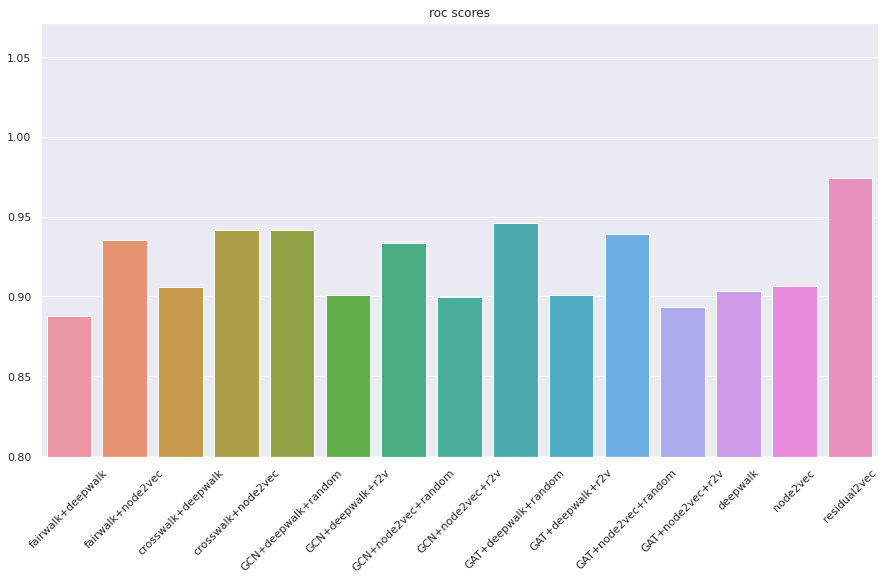

In [60]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 275.83it/s]


fairwalk+deepwalk 0.007774019339113441
fairwalk+node2vec 0.0078090709069308555
crosswalk+deepwalk 0.007948058563814303
crosswalk+node2vec 0.008163336976340653
GCN+deepwalk+random 0.008012422130117148
GCN+deepwalk+r2v 0.007260614726041092
GCN+node2vec+random 0.008196200425800677
GCN+node2vec+r2v 0.007900033609097686
GAT+deepwalk+random 0.007816481056745667
GAT+deepwalk+r2v 0.006975941375148671
GAT+node2vec+random 0.008224215967990504
GAT+node2vec+r2v 0.007827615955813813
deepwalk 0.008134801600836917
node2vec 0.008277866590415673
residual2vec 0.006665145247475022


Text(0.5, 1.0, 'statistical parity scores')

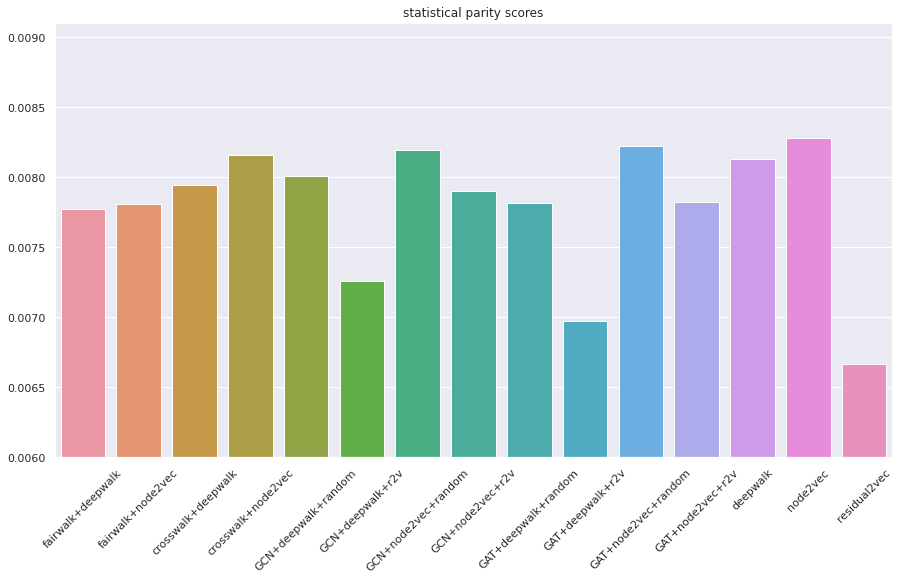

In [61]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.7318938251418785
fairwalk+node2vec 0.7311637312287872
crosswalk+deepwalk 0.7414120584461493
crosswalk+node2vec 0.7454180110482773
GCN+deepwalk+random 0.745487355582674
GCN+deepwalk+r2v 0.7180163947561484
GCN+node2vec+random 0.7459887071320075
GCN+node2vec+r2v 0.733909167982016
GAT+deepwalk+random 0.7403961015300703
GAT+deepwalk+r2v 0.7032610787569483
GAT+node2vec+random 0.7459273449458931
GAT+node2vec+r2v 0.7308803673230843
deepwalk 0.7485721882367619
node2vec 0.7479543381591046
residual2vec 0.6889349401085874


Text(0.5, 1.0, 'gini statistical parity scores')

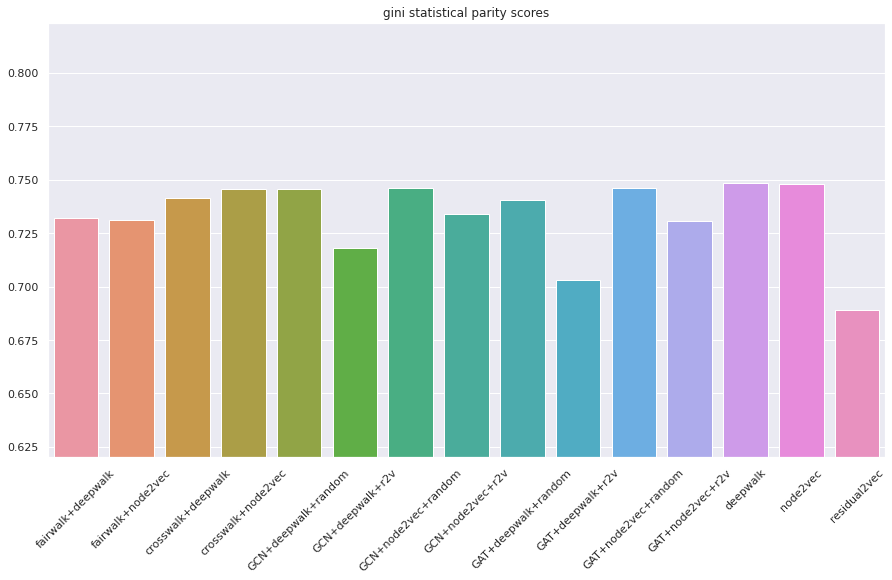

In [62]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [63]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected edge_idx size: 13674
selected edge_idx size: 13641
selected edge_idx size: 13702
selected edge_idx size: 13701
selected edge_idx size: 13673
selected e

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 228.55it/s]
